# Otto Group Product Classification Challenge

### Classify products into the correct category

The goal of this project is to do the following Kaggle challenge : https://www.kaggle.com/c/otto-group-product-classification-challenge

In [18]:
# Import

# Scientific calculations, data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as cm
import pandas as pd
import numpy as np

# Python tools
from time import time, clock
import itertools
import re

# Scikit-learn
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Depend of the version
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.lda import LDA

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

# Xgboost
from xgboost import XGBClassifier

%matplotlib inline

## Data loading and preprocessing

In [19]:
train = pd.read_csv("data/train.csv")
print(train.shape)

#Reformatons la colonne target pour avoir des entiers
train.target = train.target.str.replace('Class_','').astype(int)
train.head()

(61878, 95)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [20]:
X = train.drop(['id','target'],axis = 1)
y = train.target

In [21]:
X_off_test = pd.read_csv("data/test.csv")
print(X_off_test.shape)
X_off_test.head()

(144368, 94)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0


In [22]:
submit = pd.read_csv("data/sampleSubmission.csv")
print(submit.shape)
submit.head()

(144368, 10)


,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,1,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0


## Data visualization

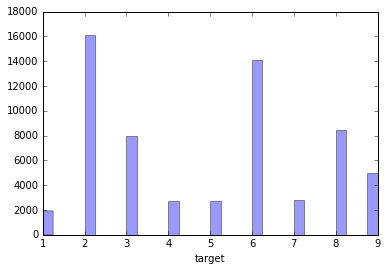

In [23]:
# Target
sns.distplot(y, kde=False, norm_hist=False)
#plt.savefig('y.png')

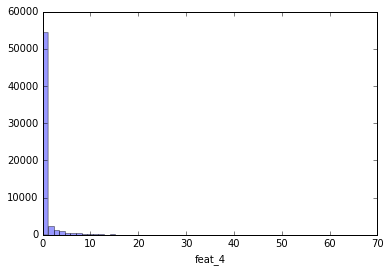

In [44]:
sns.distplot(X['feat_4'], bins=60, kde=False, norm_hist=False)
#plt.savefig('feat4.png')

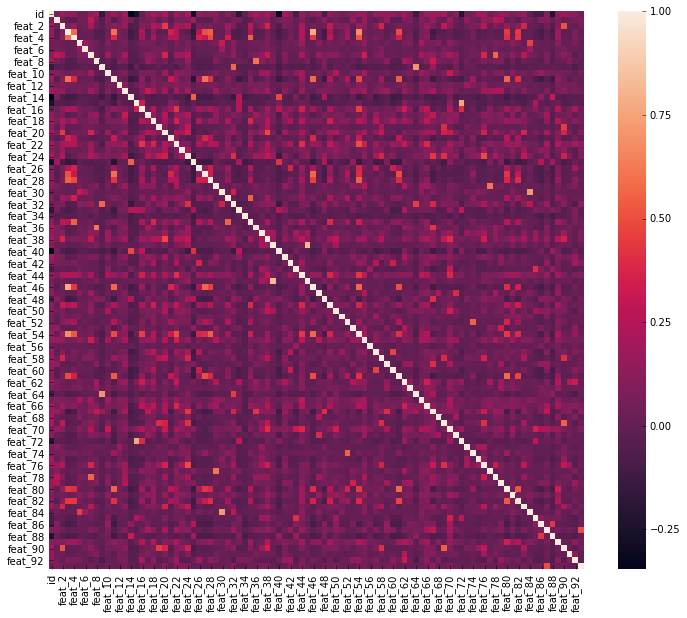

In [24]:
# Training data
plt.figure(figsize = (12,10))
sns.heatmap(train.drop('target',axis = 1).corr()) # heatmap de la matrice de corrélation

In [60]:
# Features la moins corrélée
corr = np.array(X_train.corr())
s = np.sum(np.abs(corr), axis=0)
np.argmin(s)

55

## Crossval

In [25]:
#split our dataset into train/validation/test sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

## The baseline

In [26]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

y_probas = tree.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_tree = CalibratedClassifierCV(base_estimator = DecisionTreeClassifier(),method = 'isotonic')
cal_tree.fit(X_train,y_train)

y_probas = cal_tree.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 9.8989

With calibration
Mean log_loss : 0.9078


## Classifiers comparison

Random Forest Classifier

In [12]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)

y_probas = rf.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_rf = CalibratedClassifierCV(base_estimator = RandomForestClassifier(n_jobs=-1),method = 'isotonic')
cal_rf.fit(X_train,y_train)

y_probas = cal_rf.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 1.4943

With calibration
Mean log_loss : 0.5870


XGBoost Classifier

In [15]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

y_probas = xgb.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_xgb = CalibratedClassifierCV(base_estimator = XGBClassifier(),method = 'isotonic')
cal_xgb.fit(X_train,y_train)

y_probas = cal_xgb.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 0.6483

With calibration
Mean log_loss : 0.6076


AdaBoost Classifier

In [16]:
ada = AdaBoostClassifier(random_state = 42)
ada.fit(X_train,y_train)

y_probas = ada.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_ada = CalibratedClassifierCV(base_estimator = AdaBoostClassifier(random_state = 42),method = 'isotonic')
cal_ada.fit(X_train,y_train)

y_probas = cal_ada.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 2.0262

With calibration
Mean log_loss : 1.1420


MultiLayer Perceptron Classifier

In [17]:
mlp = MLPClassifier(random_state = 42)
mlp.fit(X_train,y_train)

y_probas = mlp.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_mlp = CalibratedClassifierCV(base_estimator = MLPClassifier(random_state = 42),method = 'isotonic')
cal_mlp.fit(X_train,y_train)

y_probas = cal_mlp.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 0.6576

With calibration
Mean log_loss : 0.5209


In [61]:
mlp = MLPClassifier(hidden_layer_sizes=(200,), random_state = 42)
mlp.fit(X_train,y_train)

y_probas = mlp.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_mlp = CalibratedClassifierCV(base_estimator = MLPClassifier(hidden_layer_sizes=(200,), random_state = 42),method = 'isotonic')
cal_mlp.fit(X_train,y_train)

y_probas = cal_mlp.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 0.7910

With calibration
Mean log_loss : 0.5089


Linear Discriminant Analysis

In [18]:
lda = LDA()
lda.fit(X_train,y_train)

y_probas = lda.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_lda = CalibratedClassifierCV(base_estimator = LDA(),method = 'isotonic')
cal_lda.fit(X_train,y_train)

y_probas = cal_lda.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 0.9215


C:\Program Files\Python 3.4\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)



With calibration
Mean log_loss : 0.7603


Gaussian Naive Bayes

In [19]:
naive = GaussianNB()
naive.fit(X_train,y_train)

y_probas = naive.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_naive = CalibratedClassifierCV(base_estimator = GaussianNB(),method = 'isotonic')
cal_naive.fit(X_train,y_train)

y_probas = cal_naive.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 7.2519

With calibration
Mean log_loss : 0.8883


C:\Program Files\Python 3.4\lib\site-packages\sklearn\calibration.py:379: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


Stochastic Gradient Descent

In [21]:
sgd = SGDClassifier(loss = 'log')
sgd.fit(X_train,y_train)

y_probas = sgd.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_sgd = CalibratedClassifierCV(base_estimator = SGDClassifier(loss = 'log'),method = 'isotonic')
cal_sgd.fit(X_train,y_train)

y_probas = cal_sgd.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

C:\Program Files\Python 3.4\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Without calibration
Mean log_loss : 2.3360

With calibration
Mean log_loss : 0.8086


Gradient Boosting Classifier

In [22]:
boost = GradientBoostingClassifier(random_state = 42)
boost.fit(X_train,y_train)

y_probas = boost.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_boost = CalibratedClassifierCV(base_estimator = GradientBoostingClassifier(random_state = 42),method = 'isotonic')
cal_boost.fit(X_train,y_train)

y_probas = cal_boost.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 0.5996

With calibration
Mean log_loss : 0.6614


Logistic Regression

In [27]:
logreg = LogisticRegression(random_state = 42)
logreg.fit(X_train,y_train)

y_probas = logreg.predict_proba(X_test)
print("Without calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

cal_logreg = CalibratedClassifierCV(base_estimator = GradientBoostingClassifier(random_state = 42),method = 'isotonic')
cal_logreg.fit(X_train,y_train)

y_probas = cal_logreg.predict_proba(X_test)
print("\nWith calibration")
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Without calibration
Mean log_loss : 0.6700

With calibration
Mean log_loss : 0.6614


In [72]:
from sklearn.semi_supervised import LabelPropagation

## Some HP search

AdaBoost Classifier

In [ ]:
ada_param_grid = {'n_estimators': [50, 100, 150, 300, 600],
                  'learning_rate': [0.1, 0.2, 0.5, 1., 1.5],
                 }

ada_grid_search = GridSearchCV(estimator = AdaBoostClassifier(random_state=42),
                               param_grid = ada_param_grid,
                               cv=5, n_jobs=-1,
                               verbose = 1,
                               scoring = 'neg_log_loss')
start = time()
ada_grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(ada_grid_search.grid_scores_)))
print(ada_grid_search.best_params_)

"""Prediction with those best parameters"""

best_ada_clf = AdaBoostClassifier(n_estimators=600, learning_rate=0.5, random_state=42)
best_ada_clf.fit(X_train, y_train)

y_pred = best_ada_clf.predict(X_test)
y_probas = best_ada_clf.predict_proba(X_test)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))
print("Execution time: %.3fs" %(clock()-start))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min


Gradient Boosting Classifier

In [ ]:
gbc_param_grid = {'n_estimators': [100, 300, 600],
                  'learning_rate': [0.1, 0.2, 0.5, 1.],
                 }

gbc_grid_search = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42),
                               param_grid = gbc_param_grid,
                               cv=5, n_jobs=-1,
                               verbose = 1,
                               scoring = 'neg_log_loss')
start = time()
gbc_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gbc_grid_search.grid_scores_)))
print(gbc_grid_search.best_params_)

best_gbc_clf = gbc_grid_search.best_estimator_
best_gbc_clf.fit(X_train, y_train)

y_pred = best_gbc_clf.predict(X_test)
y_probas = best_gbc_clf.predict_proba(X_test)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Multi-Layer Perceptron Classifier

In [ ]:
nn_param_grid = { 
    'alpha': [0.0001, 0.001, 0.1, 1],
    'learning_rate_init': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'adam'],
    'activation': ['relu', 'tanh', 'logistic']
    }

nn_grid_search = GridSearchCV(estimator = MLPClassifier(random_state = 42),
                              param_grid = nn_param_grid,
                              cv = 5, n_jobs = -1,
                              verbose = 1,
                              scoring = 'neg_log_loss')
start = time()
nn_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(nn_grid_search.grid_scores_)))
print(nn_grid_search.best_params_)

best_nn = nn_grid_search.best_estimator_
best_nn.fit(X_train, y_train)

y_pred = best_nn.predict(X_test)
y_probas = best_nn.predict_proba(X_test)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Random Forest Classifier

In [ ]:
rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600],
                  'criterion': ['gini','entropy'],
                  'max_depth': [1,2,5,10,20]
                 }

rf_grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=42),
                              param_grid = rf_param_grid,
                              cv=5, n_jobs=-1,
                              verbose = 1,
                              scoring = 'neg_log_loss')
start = time()
rf_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(rf_grid_search.grid_scores_)))
print(rf_grid_search.best_params_)

best_rf_clf = rf_grid_search.best_estimator_
best_rf_clf.fit(X_train, y_train)

y_pred = best_rf_clf.predict(X_test)
y_probas = best_rf_clf.predict_proba(X_test)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

## Dimensionality reduction

For 1 components
mean logloss: 11.604
For 2 components
mean logloss: 2.836
For 3 components
mean logloss: 1.665
For 4 components
mean logloss: 1.405
For 5 components
mean logloss: 1.091
For 6 components
mean logloss: 0.937
For 7 components
mean logloss: 0.893
For 8 components
mean logloss: 0.845
For 9 components
mean logloss: 0.816
For 10 components
mean logloss: 0.798
For 11 components
mean logloss: 0.761
For 12 components
mean logloss: 0.714
For 13 components
mean logloss: 0.706
For 14 components
mean logloss: 0.699
For 15 components
mean logloss: 0.692
For 16 components
mean logloss: 0.680
For 17 components
mean logloss: 0.661
For 18 components
mean logloss: 0.664
For 19 components
mean logloss: 0.657
Computation time: 1668.45s


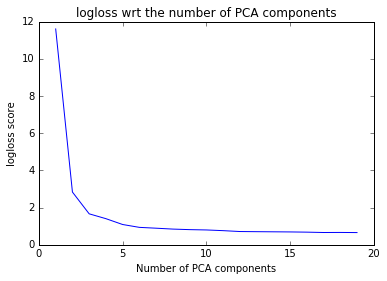

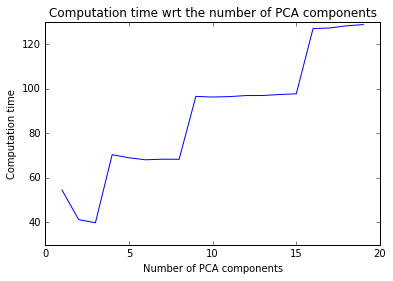

In [75]:
# Optimisation du nombre de composantes dans la PCA
tps = clock()
scores = []
times = []
model = RandomForestClassifier(n_estimators=150, criterion ='entropy')
max_comp = 20
for n_comp in range(1,max_comp):
    tps2 = clock()
    pca = PCA(n_components=n_comp)
    
    Xtr_new = pca.fit_transform(X_train,y_train)
    model.fit(Xtr_new,y_train)
    
    Xte_new = pca.transform(X_test)
    y_probas = model.predict_proba(Xte_new)
    score = log_loss(y_test,y_probas)
    
    scores.append(score)
    times.append(clock()-tps2)
    print("For %i components"%n_comp)
    print("mean logloss: %.3f"%score)

print("Computation time: %.2fs" %(clock()-tps))
plt.plot(np.arange(1,max_comp),scores)
plt.title("logloss wrt the number of PCA components")
plt.xlabel("Number of PCA components")
plt.ylabel("logloss score")
plt.figure()
plt.plot(np.arange(1,max_comp),times)
plt.title("Computation time wrt the number of PCA components")
plt.xlabel("Number of PCA components")
plt.ylabel("Computation time")

# Overfitting

In [ ]:
# Check overfitting avec le max_depth
tps = clock()
accuracies = []
max_depth = 50

tr_scores = []
te_scores = []

for depth in range(1,max_depth):
    print(depth)
    model = RandomForestClassifier(n_estimators=150, criterion ='entropy', max_depth = depth)
    model.fit(X_train,y_train)
    
    train_probas = model.predict_proba(X_train)[:,1]
    test_probas = model.predict_proba(X_test)[:,1]
    tr_score = roc_auc_score(y_train,train_probas)
    te_score = roc_auc_score(y_test,test_probas)
    tr_scores.append(tr_score)
    te_scores.append(te_score)

print("Computation time: %.2fs" %(clock()-tps))
plt.plot(np.arange(1,max_depth),tr_scores,c = 'b',label = "Train")
plt.plot(np.arange(1,max_depth),te_scores,c = 'r',label = "Test")
plt.legend()
plt.title("AUC on train and test sets wrt the depth of the trees")
plt.xlabel("max depth")
plt.ylabel("Accuracy")

## n_estimators in random forest

Computation time: 1522.16s


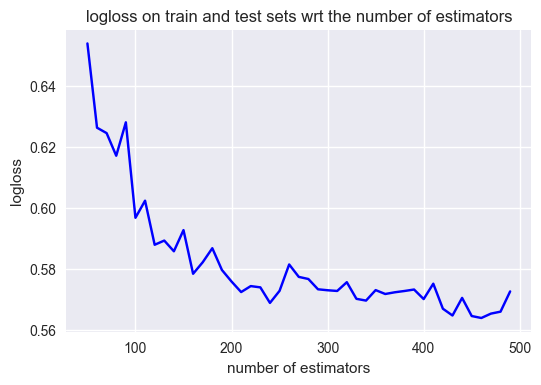

In [11]:
tps = clock()
max_est = 500
step = 10
scores = []

for nb_est in range(50,max_est,step):
    model = RandomForestClassifier(n_estimators=nb_est, criterion ='gini')
    model.fit(X_train,y_train)
    scores.append(log_loss(y_test,model.predict_proba(X_test)))

print("Computation time: %.2fs" %(clock()-tps))
plt.plot(np.arange(50,max_est,step),scores,c = 'b')
plt.title("logloss on train and test sets wrt the number of estimators")
plt.xlabel("number of estimators")
plt.ylabel("logloss")

## Learning curves

At most 49502 rows
100
1100
2100
3100
4100
5100
6100
7100
8100
9100
10100
11100
12100
13100
14100
15100
16100
17100
18100
19100
20100
21100
22100
23100
24100
25100
26100
27100
28100
29100
30100
31100
32100
33100
34100
35100
36100
37100
38100
39100
40100
41100
42100
43100
44100
45100
46100
47100
48100
49100
Execution time: 3228.205s


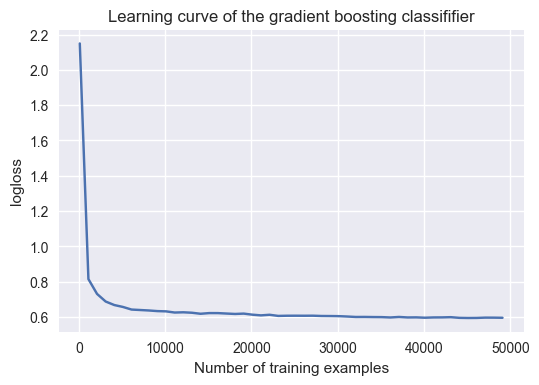

In [15]:
tps = clock()
scores = []
start,stop,step = 100,len(X_train),1000
print("At most %i rows" %len(X_train))

#best_gbc_clf = GradientBoostingClassifier(random_state = 42, learning_rate = 0.2, n_estimators = 600)
best_gbc_clf = GradientBoostingClassifier()
    
for nb_rows in range(start,stop,step):
    print(nb_rows)
    # On utilise ici un classifieur par gradientboosting avec les meilleurs HP trouvés
    best_gbc_clf.fit(X_train[:nb_rows], y_train[:nb_rows])
    scores.append(log_loss(y_test,best_gbc_clf.predict_proba(X_test),labels = [1,2,3,4,5,6,7,8,9]))
    
plt.plot(np.arange(start,stop,step),scores)
plt.title('Learning curve of the gradient boosting classififier')
plt.xlabel('Number of training examples')
plt.ylabel('logloss')
print("Execution time: %.3fs" %(clock()-tps))

At most 49502 rows
Execution time: 309.647s


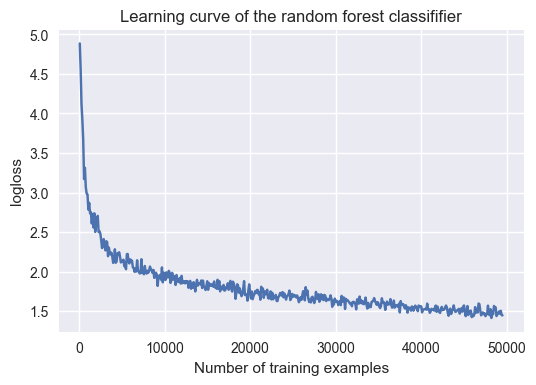

In [16]:
tps = clock()
scores = []
start,stop,step = 100,len(X_train),100
print("At most %i rows" %len(X_train))

best_rf_clf = RandomForestClassifier()

for nb_rows in range(start,stop,step):
    # On utilise ici un classifieur par random forest avec les meilleurs HP trouvés
    best_rf_clf.fit(X_train[:nb_rows], y_train[:nb_rows])
    scores.append(log_loss(y_test,best_rf_clf.predict_proba(X_test),labels = [1,2,3,4,5,6,7,8,9]))
    
plt.plot(np.arange(start,stop,step),scores)
plt.title('Learning curve of the random forest classififier')
plt.xlabel('Number of training examples')
plt.ylabel('logloss')
print("Execution time: %.3fs" %(clock()-tps))

## Feature construction

In [42]:
#With a normal RAM capacity, let's only take the top 10 xgboost features
cols = X.columns
X_new = X.copy()

#Select the features
feature_import = xgb.feature_importances_
FI = pd.DataFrame()
FI['Feature']= cols
FI['Importance'] = feature_import
FI.sort_values(by='Importance', ascending=False, inplace=True)
features = FI.head(10).Feature.values

#Creste the new columns
for feat in features:
    for feat2 in features:
        X_new[feat + ' * ' + feat2] = (X_new[feat] * X_new[feat2])
        X_new[feat + ' max ' + feat2] = pd.concat([X_new[feat],X_new[feat2]],axis = 1).max(axis = 1)
        
X_train_new, X_test_new,_,_ = train_test_split(X_new,y, test_size = 0.2, random_state=42)

print("Before the feature construction: %i columns" %len(feature_import))
print("After it: %i columns" %X_new.shape[1])
X_new.head()

Before the feature construction: 93 columns
After it: 293 columns


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86 * feat_67,feat_86 max feat_67,feat_86 * feat_60,feat_86 max feat_60,feat_86 * feat_14,feat_86 max feat_14,feat_86 * feat_25,feat_86 max feat_25,feat_86 * feat_86,feat_86 max feat_86
0,1,0,0,0,0,0,0,0,0,0,...,0,7,0,11,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,6,0,0,0,0,0,0,0,0
3,1,0,0,1,6,1,5,0,0,1,...,5,5,0,1,0,1,2,2,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
start = clock()
#Random Forest
RF2 = RandomForestClassifier(n_estimators=150, criterion ='gini',random_state=42, n_jobs=-1)
RF2.fit(X_train_new,y_train)
y_probas = RF2.predict_proba(X_test_new)
print("Random Forest : %.4f" %log_loss(y_test,y_probas))

#Xgboost
xgb2 = XGBClassifier()
xgb2.fit(X_train_new,y_train)
y_probas = xgb2.predict_proba(X_test_new)
print("Xgboost : %.4f" %log_loss(y_test,y_probas))

#AdaBoost
ada2 = AdaBoostClassifier(n_estimators=600, learning_rate=0.5, random_state = 42)
ada2.fit(X_train_new,y_train)
y_probas = ada2.predict_proba(X_test_new)
print("Adaboost : %.4f" %log_loss(y_test,y_probas))

#MLPClassifier
mlp2 = MLPClassifier(random_state = 42)
mlp2.fit(X_train_new,y_train)
y_probas = mlp2.predict_proba(X_test_new)
print("Multi layer perceptron : %.4f" %log_loss(y_test,y_probas))

#LDA
lda2 = LDA()
lda2.fit(X_train_new,y_train)
y_probas = lda2.predict_proba(X_test_new)
print("Linear discriminant analysis : %.4f" %log_loss(y_test,y_probas))

#GaussianNB
naive2 = GaussianNB()
naive2.fit(X_train_new,y_train)
y_probas = naive2.predict_proba(X_test_new)
print("Gaussian naive bayes : %.4f" %log_loss(y_test,y_probas))

#Apparemment il produit des nan
#SGDClassifier
#sgd2 = SGDClassifier(loss = 'log')
#sgd2.fit(X_train_new,y_train)
#y_probas = sgd2.predict_proba(X_test_new)
#print("SVM with SGD : %.4f" %log_loss(y_test,y_probas))

#DecisionTree
tree2 = DecisionTreeClassifier()
tree2.fit(X_train_new,y_train)
y_probas = tree2.predict_proba(X_test_new)
print("Decision tree : %.4f" %log_loss(y_test,y_probas))

#GradientBoostingTree
boost2 = GradientBoostingClassifier(random_state = 42)
boost2.fit(X_train_new,y_train)
y_probas = boost2.predict_proba(X_test_new)
print("Gradient boosting : %.4f" %log_loss(y_test,y_probas))


print("Execution time: %.3fs" %(clock()-start))

Random Forest : 0.6548
Xgboost : 0.6290
Adaboost : 2.1223
Multi linear perceptron : 0.6200


C:\Program Files\Python 3.4\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Linear discriminant analysis : 0.8861
Gaussian naive bayes : 13.5099
Decision tree : 9.9017
Gradient boosting : 0.5867
Execution time: 1195.352s


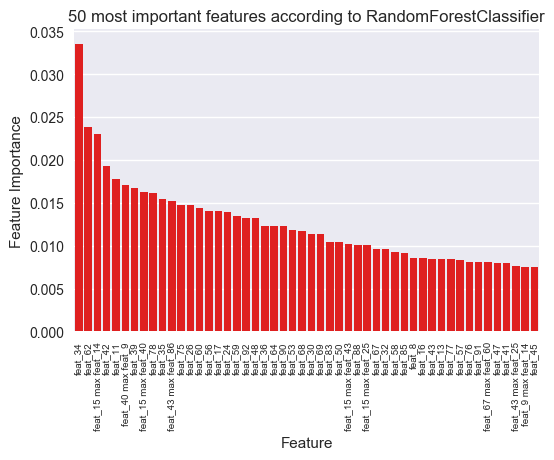

In [49]:
#analyzing feature importance
feature_import = xgb2.feature_importances_
FI = pd.DataFrame()
FI['Feature']= X_new.columns
FI['Importance'] = feature_import
FI.sort_values(by='Importance', ascending=False, inplace=True)
ax = sns.barplot(FI['Feature'].iloc[:50], FI['Importance'].iloc[:50], color='r')
plt.title('50 most important features according to RandomForestClassifier')
plt.xlabel('Feature')
for item in ax.get_xticklabels():
    item.set_fontsize(7)
    
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')

## Feature importance

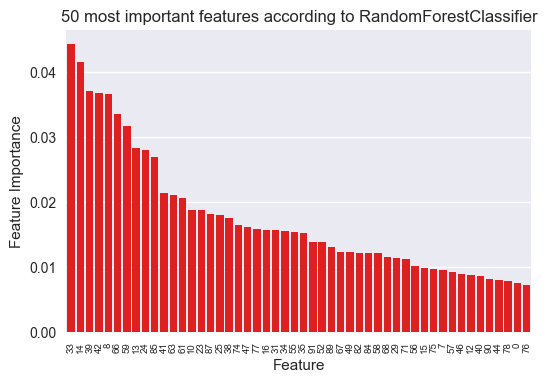

In [50]:
#analyzing feature importance
feature_import = xgb.feature_importances_
FI = pd.DataFrame()
FI['Feature']= np.arange(X.shape[1])
FI['Importance'] = feature_import
FI.sort_values(by='Importance', ascending=False, inplace=True)
ax = sns.barplot(FI['Feature'].iloc[:50], FI['Importance'].iloc[:50], color='r', order = FI['Feature'].iloc[:50])
plt.title('50 most important features according to RandomForestClassifier')
plt.xlabel('Feature')
for item in ax.get_xticklabels():
    item.set_fontsize(7)
    
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')

## Stacking

In [124]:
class my_stacking():
    
    def __init__(self,models = None,nfolds = 5,top_clf = XGBClassifier(),labels = [0,1],random_state = 42,recalibration = 0):
        
        self.random_state = random_state
        if models is None:
            models = {'Decision tree': DecisionTreeClassifier(random_state = self.random_state),
                     'Random forest': RandomForestClassifier(n_jobs = -1, random_state = self.random_state),
                     'Xgboost': XGBClassifier(),
                     'Gradient boosting': GradientBoostingClassifier(random_state = self.random_state),
                     'Adaboost': AdaBoostClassifier(random_state = self.random_state),
                     'Mlp': MLPClassifier(random_state = self.random_state),
                     'Lda': LDA(),
                     'Naive': GaussianNB(),
                     'SVM': SGDClassifier(loss = 'log', random_state = self.random_state),
                     'Reglog': LogisticRegression(random_state = self.random_state)}
        is self.recalibration == 2:
            #Trouver la bonne dict comprehension ici
            self.models = models
        else:
            self.models = models
        self.recalibration = recalibration
        if self.recalibration > 0:
            self.top_clf = CalibratedClassifierCV(base_estimator = top_clf,method = 'isotonic')
        else:
            self.top_clf = top_clf
        self.model_names = list(self.models.keys())
        self.kfold = KFold(n_splits = nfolds,random_state = self.random_state)
        self.labels = labels
            
    def fit(self, Xtr, Ytr):
        second_layer_tr = pd.DataFrame(index = Xtr.index)
        
        for train_index,test_index in self.kfold.split(Xtr):
            Xtrtr, Ytrtr = Xtr.loc[Xtr.index[train_index]], Ytr.loc[Xtr.index[train_index]]
            Xtrte, Ytrte = Xtr.loc[Xtr.index[test_index]], Ytr.loc[Xtr.index[test_index]]
            
            for model in self.model_names:
                self.models[model].fit(Xtrtr,Ytrtr)
                preds = self.models[model].predict_proba(Xtrte)
                
                for i in range(len(self.labels)):
                    second_layer_tr.loc[Xtr.index[test_index], model+'_class_'+str(self.labels[i])] = preds[:,i]
                
        self.second_layer_tr = second_layer_tr
        
        self.top_clf.fit(second_layer_tr,Ytr)
        for model in self.model_names:
            self.models[model].fit(Xtr,Ytr)
            
    def predict(self, Xte):
        second_layer_te = pd.DataFrame(index = Xte.index)
        for model in self.model_names:
            preds = self.models[model].predict_proba(Xte)
            
            for i in range(len(self.labels)):
                second_layer_te[model+'_class_'+str(self.labels[i])] = preds[:,i]
                
        self.second_layer_te = second_layer_te
        return self.top_clf.predict(second_layer_te)
    
    def predict_proba(self, Xte):
        second_layer_te = pd.DataFrame(index = Xte.index)
        for model in self.model_names:
            preds = self.models[model].predict_proba(Xte)
            
            for i in range(len(self.labels)):
                second_layer_te[model+'_class_'+str(self.labels[i])] = preds[:,i]
                
        self.second_layer_te = second_layer_te
        return self.top_clf.predict_proba(second_layer_te)

In [ ]:
my_stack = my_stacking(labels = range(1,10))
my_stack.fit(X_train,y_train)
y_preds = my_stack.predict_proba(X_test)
print("Log_loss of the stacking classifier : %.4f" %log_loss(y_test,y_preds, labels = my_stack.labels))

C:\Program Files\Python 3.4\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Program Files\Python 3.4\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [ ]:
for target in range(9):
    temp = my_stack.second_layer_tr[[model+'_class_'+str(target+1) for model in my_stack.model_names]]
    plt.figure()
    sns.heatmap(temp.corr(),annot=True)
    plt.title('Correlation matrix for class '+str(target+1))
    plt.show()

In [58]:
stacking_model = GradientBoostingClassifier(random_state = 42, n_estimators = 300, learning_rate = 0.2)
stacking_model.fit(second_layer_tr,y_train)

second_layer_te = pd.DataFrame()
for model in models:
    preds = model_dict[model].predict_proba(X_test)
    for i in range(9):
        second_layer_te[model+'_class_'+str(i+1)] = preds[:,i]

y_probas = stacking_model.predict_proba(second_layer_te)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

Mean log_loss : 2.6850


C:\Program Files\Python 3.4\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


#### 2/ With one calibration (top layer)

In [ ]:
model_dict = {'Decision_tree':tree,
              'random_forest':RF,
              'xgboost':xgb,
              'gradient_boosting':boost,
              'adaboost':ada,
              'multi_linear_perceptron':mlp,
              'linear_discriminant_analysis':lda,
             'naive_bayes':naive,
             'sgd':sgd}
models = ['Decision_tree','random_forest','xgboost','gradient_boosting','adaboost','multi_linear_perceptron',
          'linear_discriminant_analysis','naive_bayes','sgd']

second_layer_tr2 = pd.DataFrame()
for model in models:
    preds = model_dict[model].predict_proba(X_train)
    for i in range(9):
        second_layer_tr2[model+'_class_'+str(i+1)] = preds[:,i]

In [ ]:
stack_cal_boost = CalibratedClassifierCV(base_estimator = GradientBoostingClassifier(random_state = 42),method = 'isotonic')
stack_cal_boost.fit(second_layer_tr,y_train)

second_layer_te2 = pd.DataFrame()
for model in models:
    preds = model_dict[model].predict_proba(X_test)
    for i in range(9):
        second_layer_te2[model+'_class_'+str(i+1)] = preds[:,i]

y_probas = stacking_model.predict_proba(second_layer_te2)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

#### 3/ With two calibrations

In [ ]:
model_dict = {'Decision_tree':cal_tree,
              'random_forest':cal_RF,
              'xgboost':cal_xgb,
              'gradient_boosting':cal_boost,
              'adaboost':cal_ada,
              'multi_linear_perceptron':cal_mlp,
              'linear_discriminant_analysis':cal_lda,
             'naive_bayes':cal_naive,
             'sgd':cal_sgd}
models = ['Decision_tree','random_forest','xgboost','gradient_boosting','adaboost','multi_linear_perceptron',
          'linear_discriminant_analysis','naive_bayes','sgd']

second_layer_tr3 = pd.DataFrame()
for model in models:
    preds = model_dict[model].predict_proba(X_train)
    for i in range(9):
        second_layer_tr3[model+'_class_'+str(i+1)] = preds[:,i]

In [ ]:
for target in range(9):
    temp = second_layer_tr3[[model+'_class_'+str(target+1) for model in models]]
    plt.figure()
    sns.heatmap(temp.corr(),annot=True)
    plt.title('Correlation matrix for class '+str(target+1))
    plt.show()

In [ ]:
stack_cal_boost = CalibratedClassifierCV(base_estimator = GradientBoostingClassifier(random_state = 42),method = 'isotonic')
stack_cal_boost.fit(second_layer_tr,y_train)

second_layer_te3 = pd.DataFrame()
for model in models:
    preds = model_dict[model].predict_proba(X_test)
    for i in range(9):
        second_layer_te3[model+'_class_'+str(i+1)] = preds[:,i]

y_probas = stacking_model.predict_proba(second_layer_te3)
print("Mean log_loss : %.4f" %log_loss(y_test,y_probas))

In [57]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)